## ARIMA model (p, q, d)

AR 'Auto Regressive' p => linear regression model that usues its own lags as predictiors

MA 'Moving Average' q =>  number of lagged forecast errors that should go into the ARIMA Model

d - minimum number of differencing needed to make the series stationary

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [40]:
# !pip install pmdarima
# !pip install statsmodels

In [41]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import statsmodels
import datetime as dt
import math
import pmdarima



from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_predict
from scipy import signal
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM


In [42]:
data_path = "/content/drive/MyDrive/PK Data Science/master/codes/water_availability_prediction_in_Italy/data/"
river_arno_csv_name = "River_Arno.csv"
df = pd.read_csv(data_path+river_arno_csv_name)

In [43]:
df.index = pd.to_datetime(df.Date)

In [44]:
df_date_range = pd.date_range(start='1998-01-01', end='2020-12-06')
list_of_missing_dates = df_date_range.difference(df.index)
df_missing = pd.DataFrame(index=list_of_missing_dates, columns=df.columns)
df_with_missing = pd.concat([df, df_missing])
df_with_missing.drop('Date', axis=1, inplace=True)
df_with_missing.sort_index(inplace=True)
df_with_missing.isnull().sum()

Rainfall_Le_Croci            2350
Rainfall_Cavallina           2350
Rainfall_S_Agata             2350
Rainfall_Mangona             2350
Rainfall_S_Piero             2350
Rainfall_Vernio              4093
Rainfall_Stia                7093
Rainfall_Consuma             7093
Rainfall_Incisa              3808
Rainfall_Montevarchi         6729
Rainfall_S_Savino            7093
Rainfall_Laterina            7093
Rainfall_Bibbiena            5998
Rainfall_Camaldoli           7093
Temperature_Firenze          2184
Hydrometry_Nave_di_Rosano     207
dtype: int64

In [45]:
ts = df_with_missing[(df_with_missing.index < "2017-01-01") & (df_with_missing.index > "2003-12-31")]
ts = ts[['Hydrometry_Nave_di_Rosano']].copy()

In [46]:
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

In [47]:
ts['Hydrometry_Nave_di_Rosano'] = seasonal_mean(ts['Hydrometry_Nave_di_Rosano'], n=12, lr=1.25)
ts.sort_index(inplace=True)

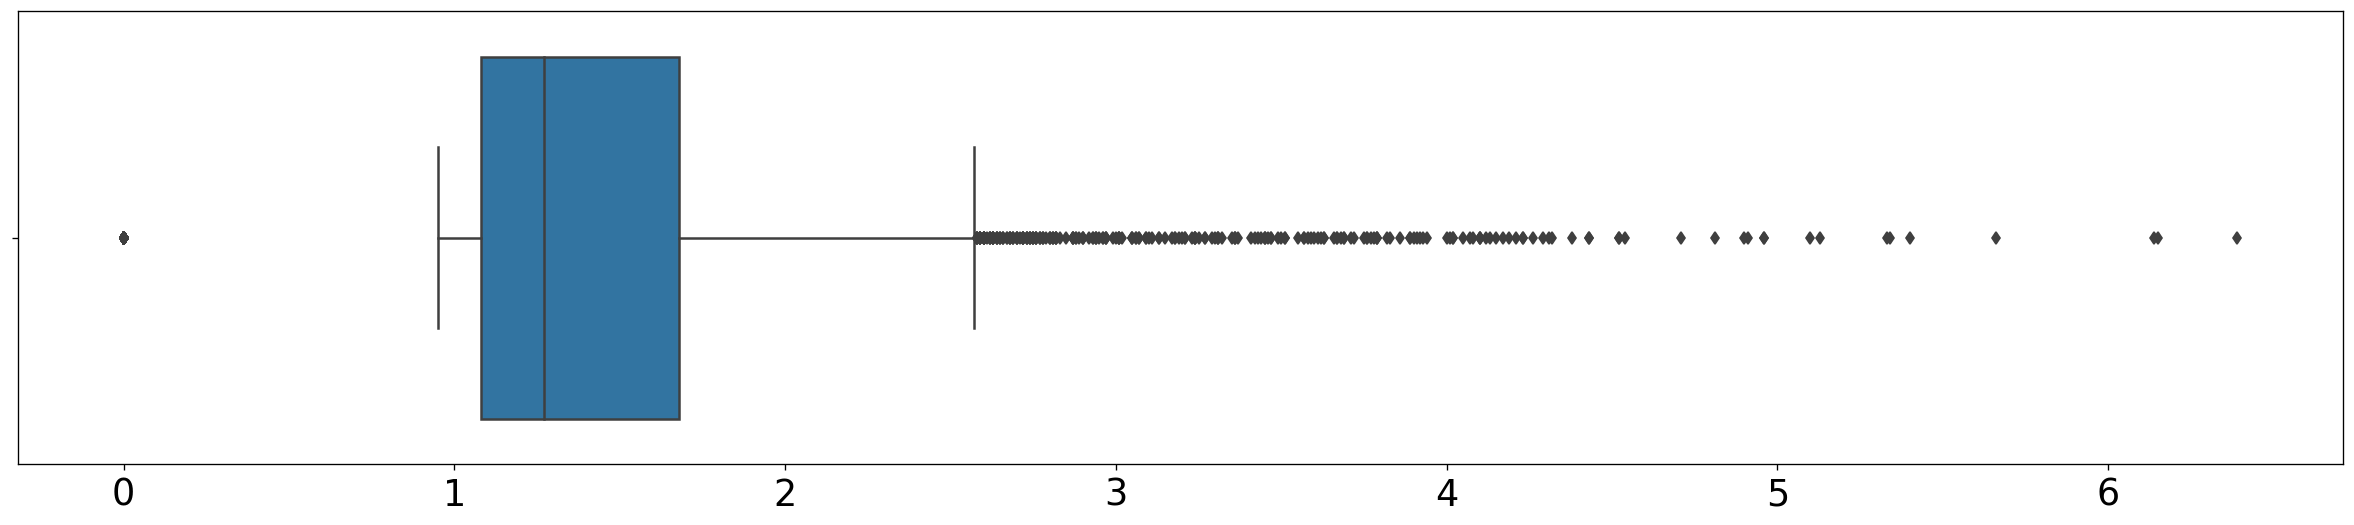

In [48]:
fig = plt.figure(figsize=(25,5))
sns.boxplot(x=ts.values)
plt.show()

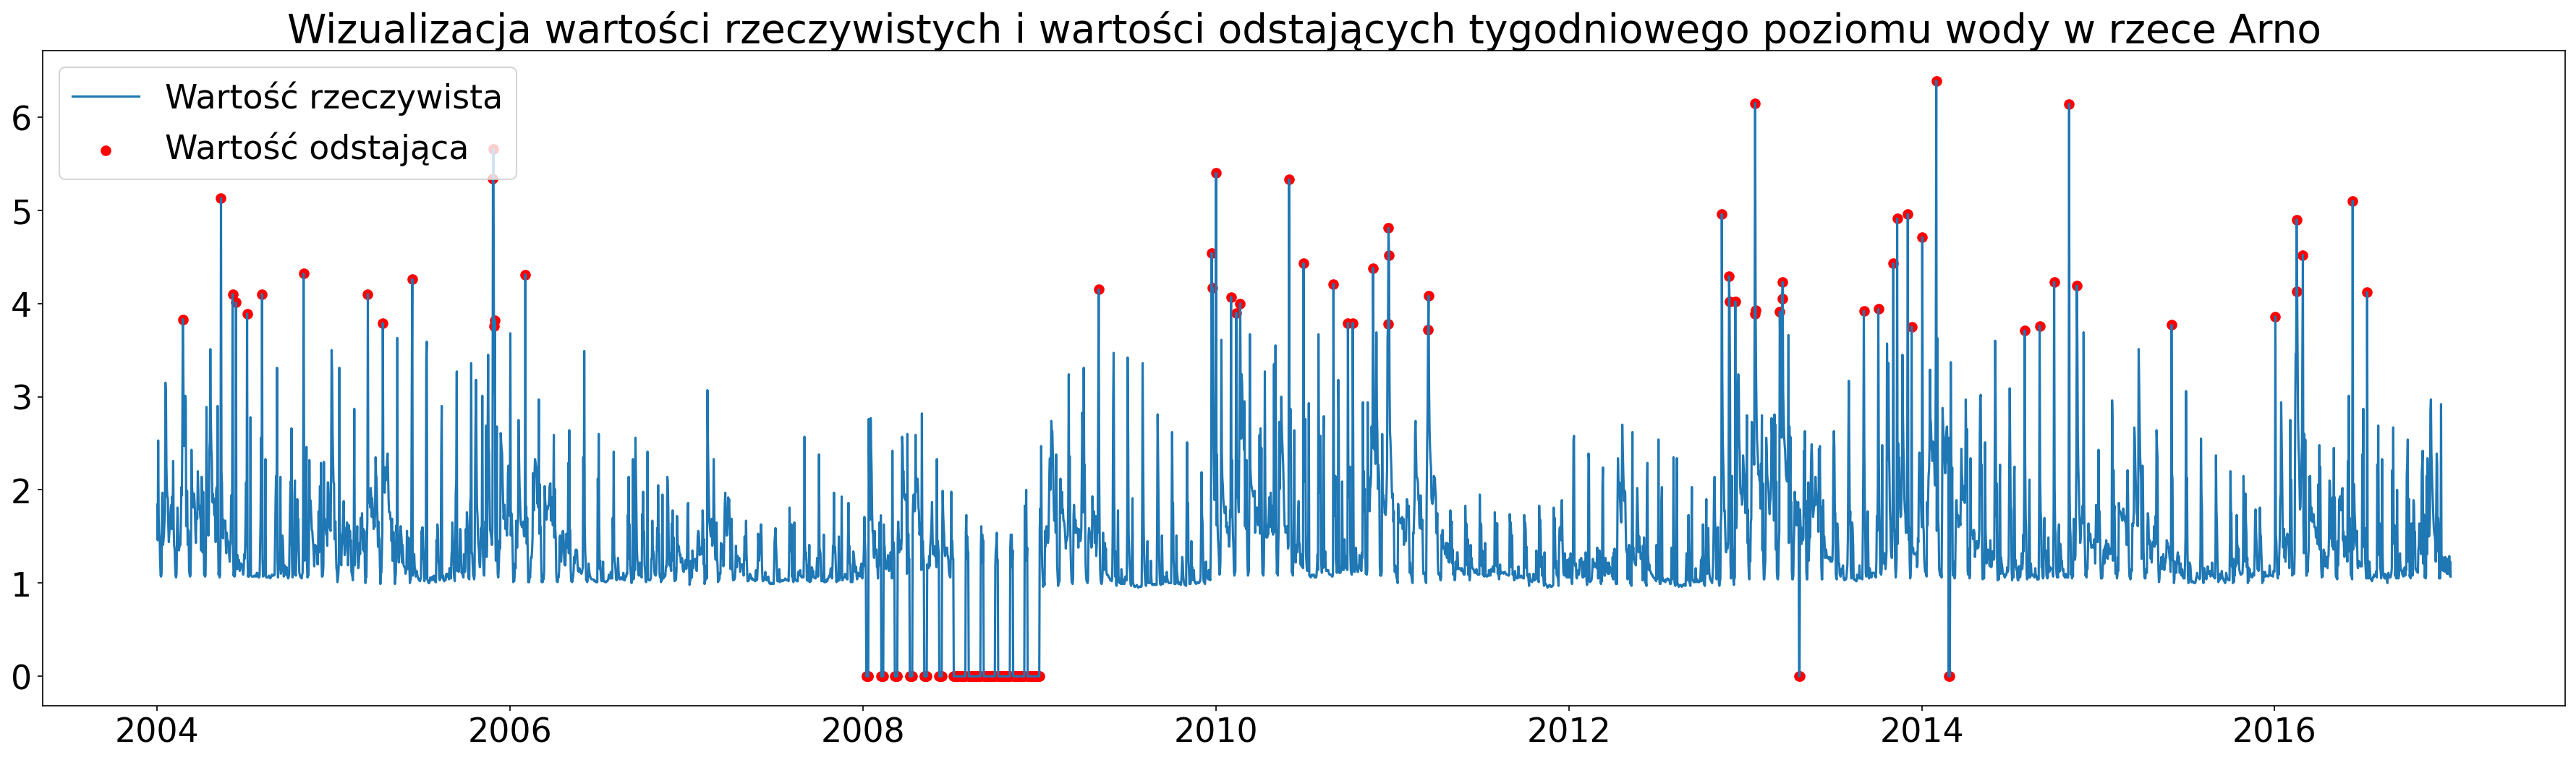

In [49]:
data = ts[['Hydrometry_Nave_di_Rosano']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
outliers_fraction=0.03
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)
ts['anomaly'] = model.predict(data)

a = ts.loc[ts['anomaly'] == -1, ['Hydrometry_Nave_di_Rosano']] #anomaly


plt.figure(figsize=(30,8), dpi=150)
plt.rcParams.update({'font.size': 22})
plt.plot(ts.index, ts['Hydrometry_Nave_di_Rosano'],  label='Wartość rzeczywista')
plt.scatter(a.index,a['Hydrometry_Nave_di_Rosano'], color='red', label='Wartość odstająca')
plt.legend(loc="upper left")
plt.title('Wizualizacja wartości rzeczywistych i wartości odstających tygodniowego poziomu wody w rzece Arno')
plt.show()
plt.show();

In [50]:
mask = ts.anomaly == -1
ts.loc[mask, 'Hydrometry_Nave_di_Rosano'] = np.NaN
ts['Hydrometry_Nave_di_Rosano'] = seasonal_mean(ts['Hydrometry_Nave_di_Rosano'], n=12, lr=1.25)
ts.sort_index(inplace=True)

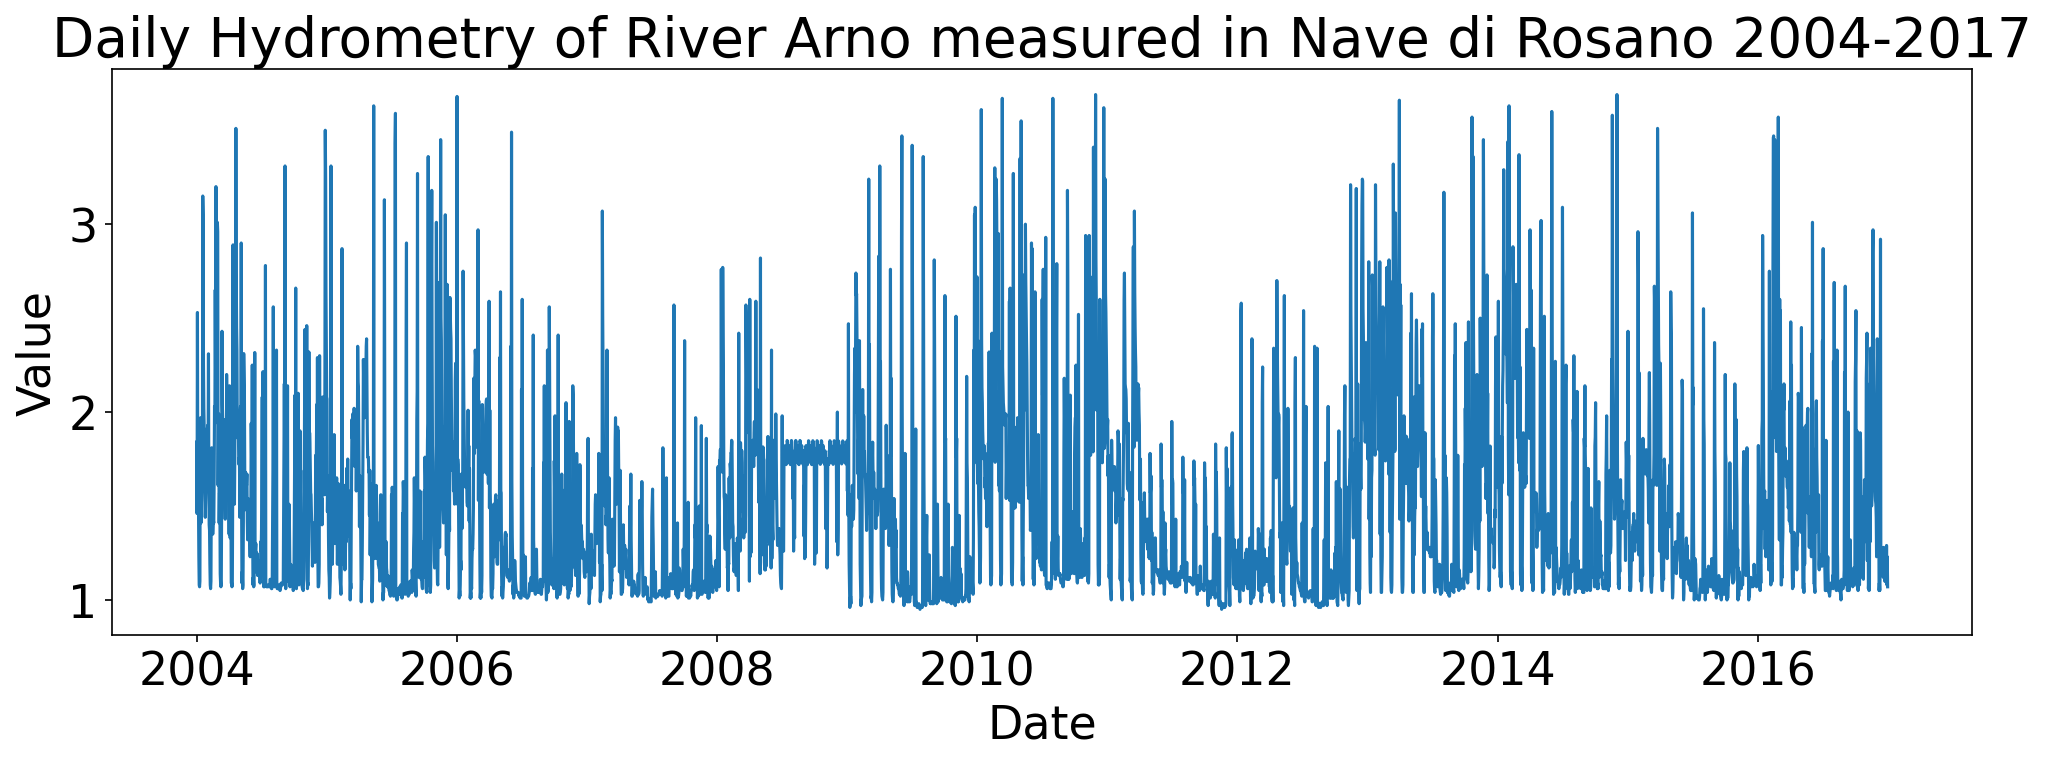

In [51]:
def plot_df(y, title="", xlabel='Date', ylabel='Value', dpi=150, **xarg):
    plt.figure(figsize=(16,5), dpi=dpi)
    x = xarg.get('x')
    if x is None:
      plt.plot(y)
    else:
      plt.plot(x, y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(y=ts.Hydrometry_Nave_di_Rosano, title='Daily Hydrometry of River Arno measured in Nave di Rosano 2004-2017', x=ts.index)

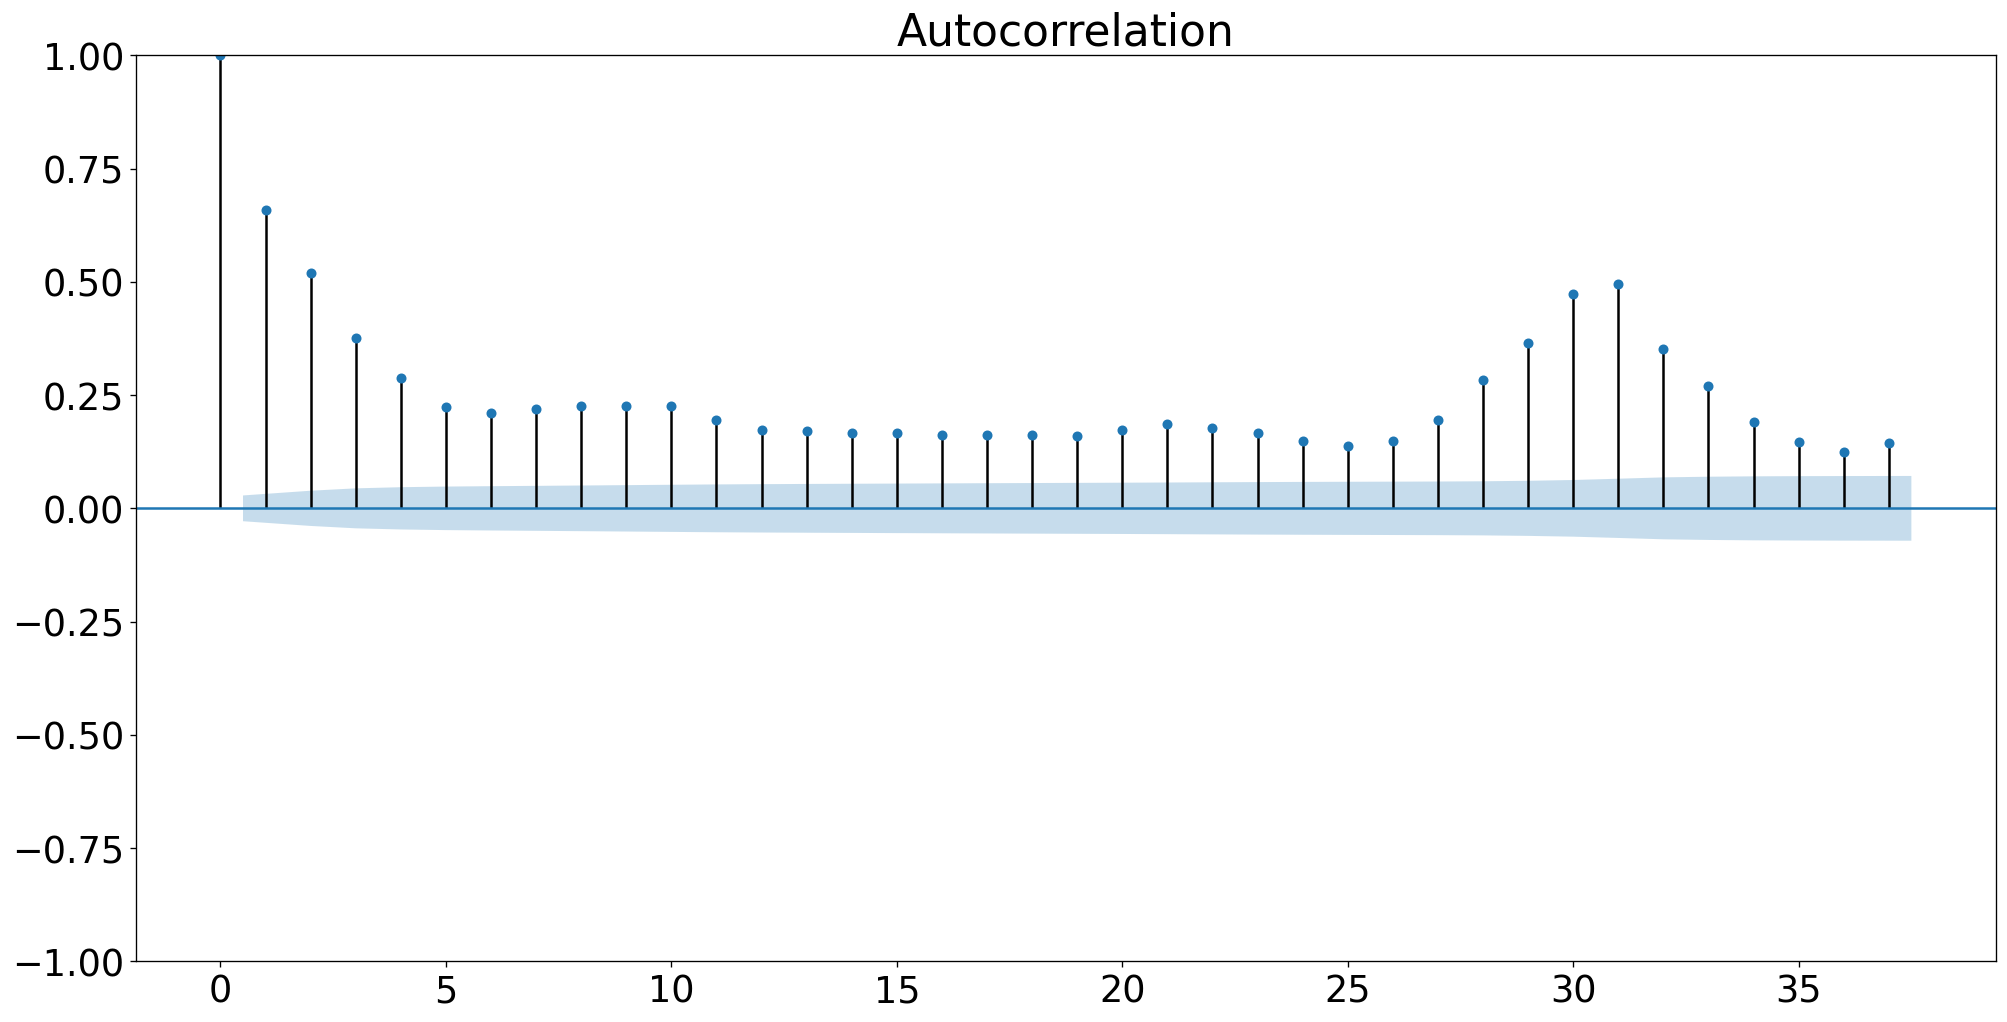

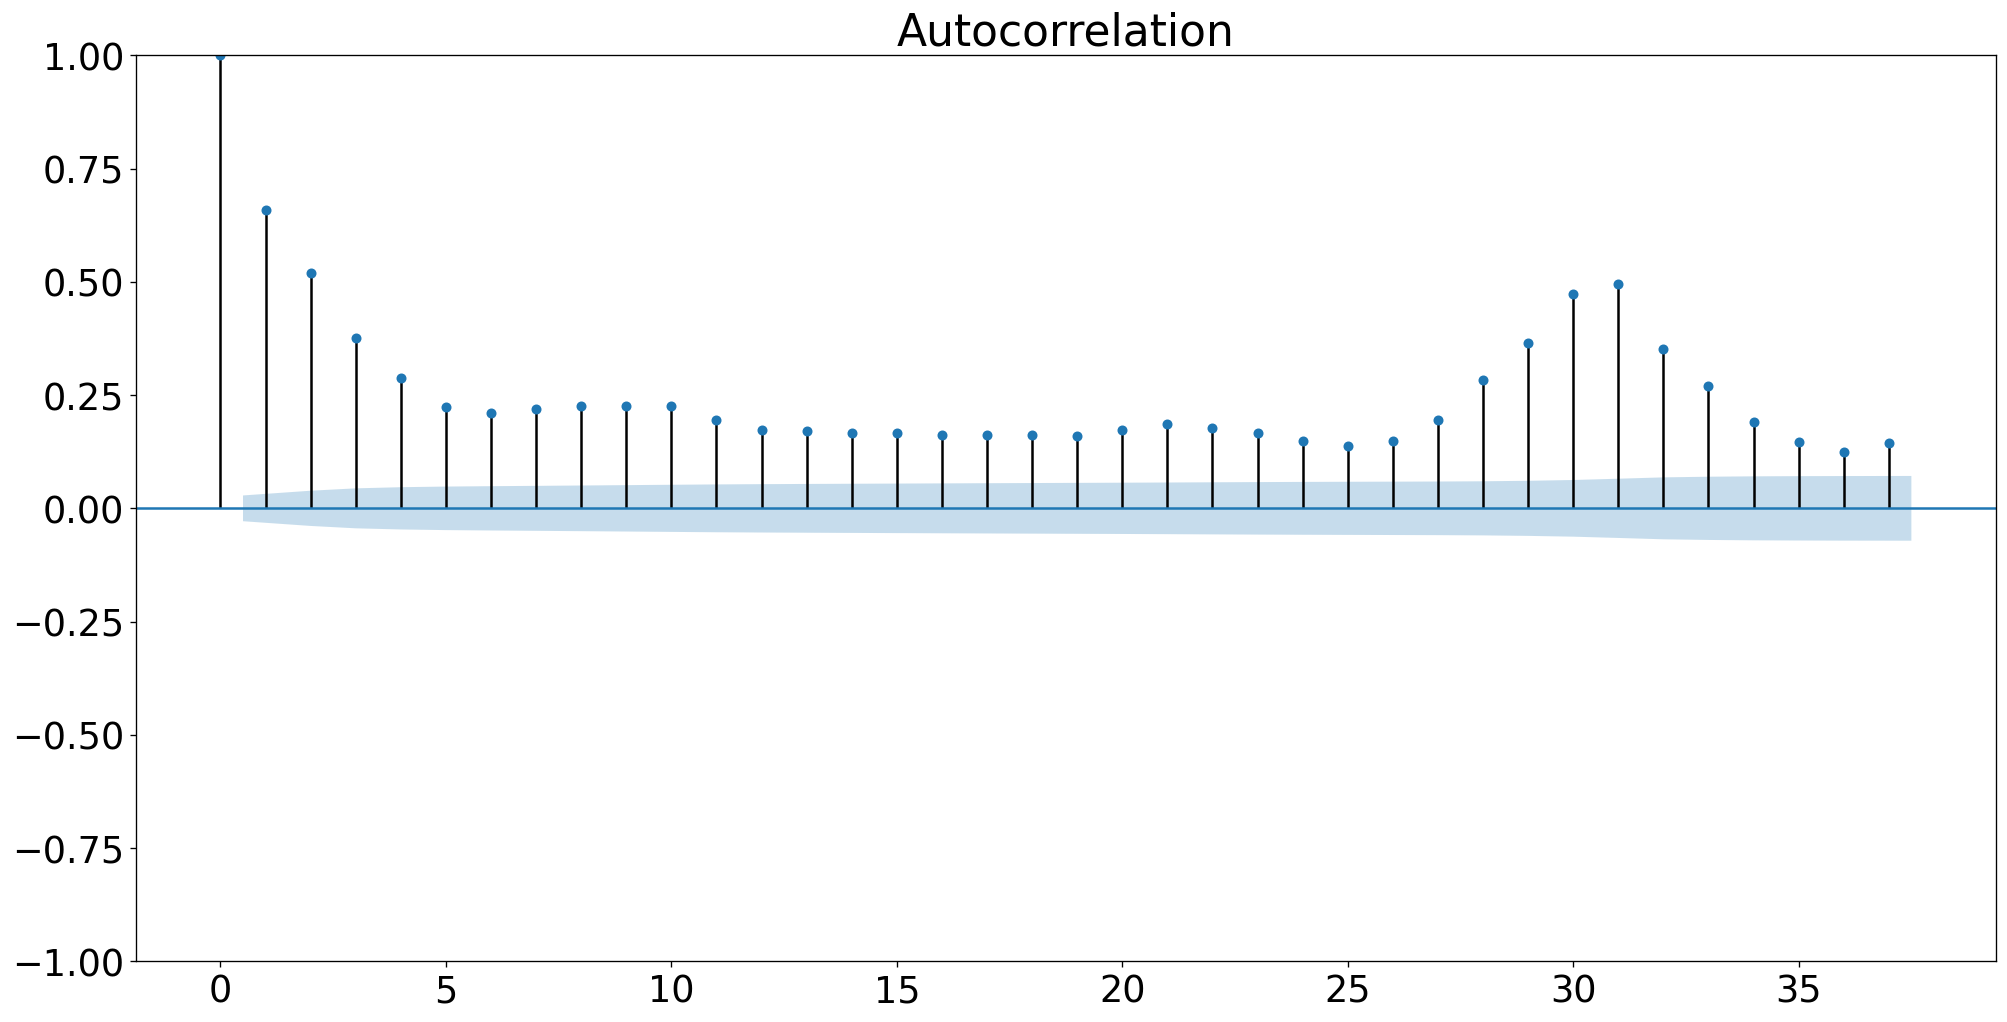

In [52]:
plot_acf(ts.Hydrometry_Nave_di_Rosano)

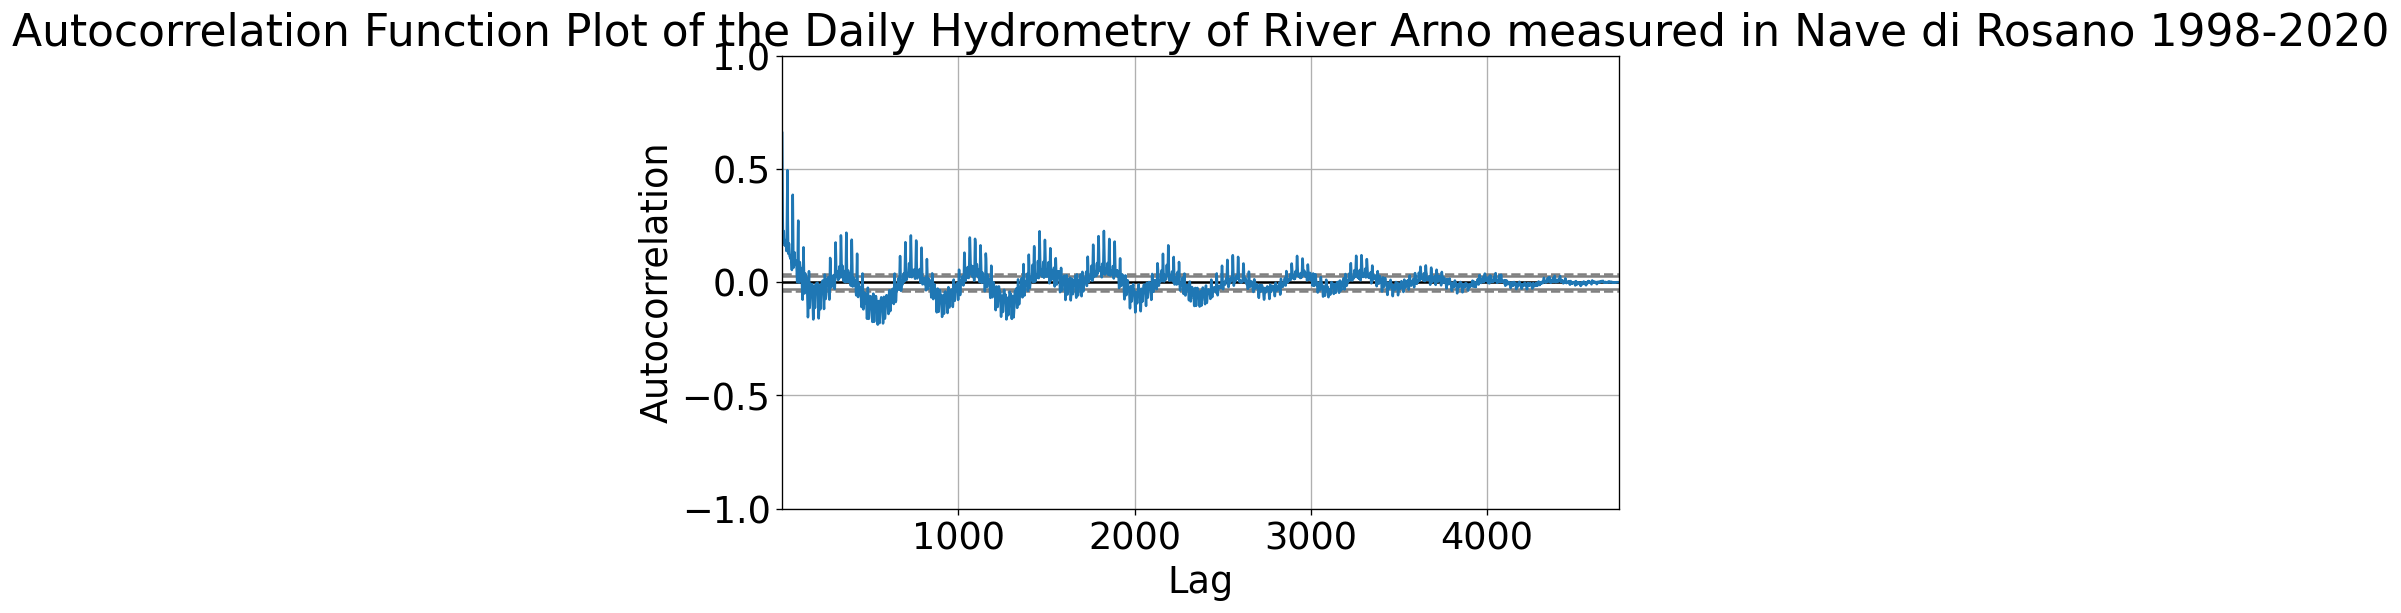

In [53]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
plt.title('Autocorrelation Function Plot of the Daily Hydrometry of River Arno measured in Nave di Rosano 1998-2020')
autocorrelation_plot(ts.Hydrometry_Nave_di_Rosano)

In [54]:
ts_group_by_month = ts['Hydrometry_Nave_di_Rosano'].groupby([ts.index.year, ts.index.month]).mean()
ts_group_by_month

2004  1     1.746774
      2     1.869914
      3     1.710000
      4     1.865333
      5     1.584238
              ...   
2016  8     1.278387
      9     1.304333
      10    1.460323
      11    1.791667
      12    1.361290
Name: Hydrometry_Nave_di_Rosano, Length: 156, dtype: float64

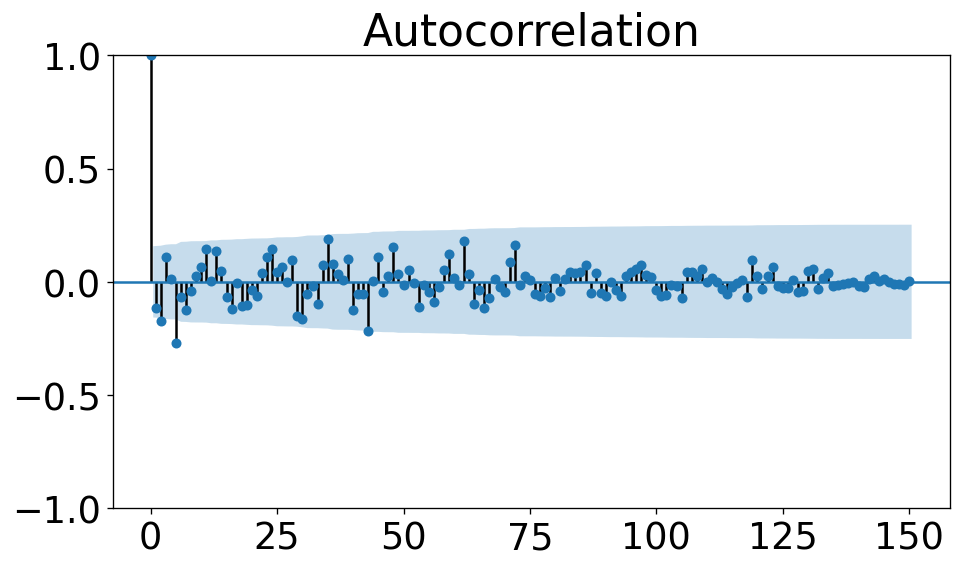

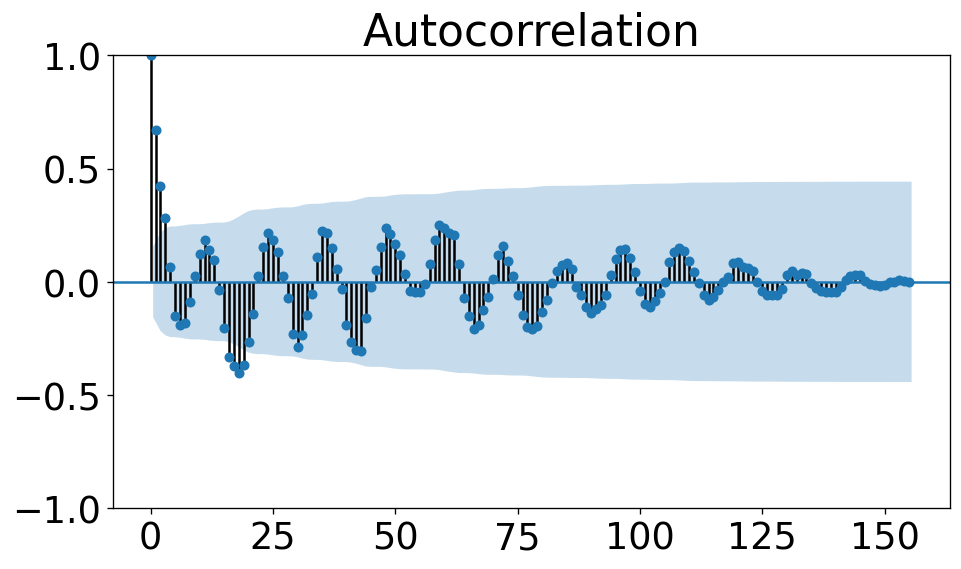

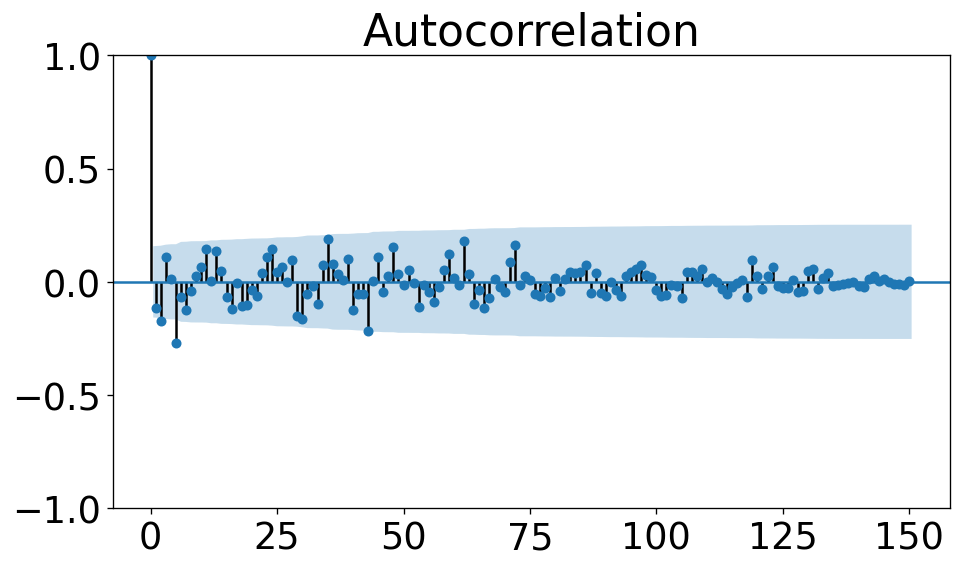

In [55]:
plot_acf(ts_group_by_month, lags=155)
plot_acf(ts_group_by_month.diff().dropna(), lags=150)


In [56]:
def difference_time_series(X, days_in_year):
	diff = list()
	for i in range(days_in_year, len(X)):
		value = X[i] - X[i - days_in_year]
		diff.append(value)
	return diff

In [57]:
days_in_year = 365
diff = difference_time_series(ts.Hydrometry_Nave_di_Rosano, days_in_year)
diff = difference_time_series(diff, days_in_year)
diff = difference_time_series(diff, days_in_year)
diff = difference_time_series(diff, days_in_year)
diff = difference_time_series(diff, days_in_year)
diff = difference_time_series(diff, days_in_year)
diff = difference_time_series(diff, days_in_year)
ts_diff = pd.DataFrame(diff)

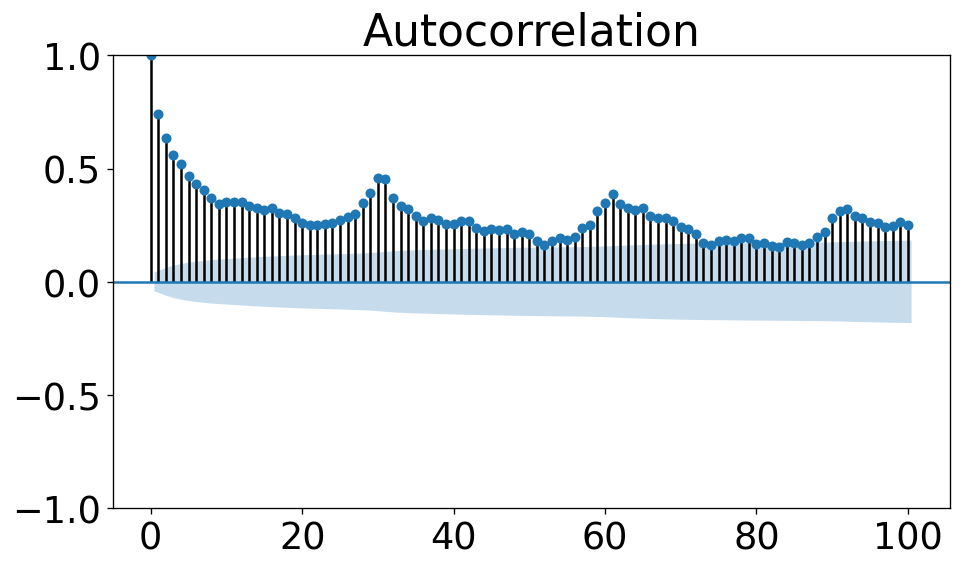

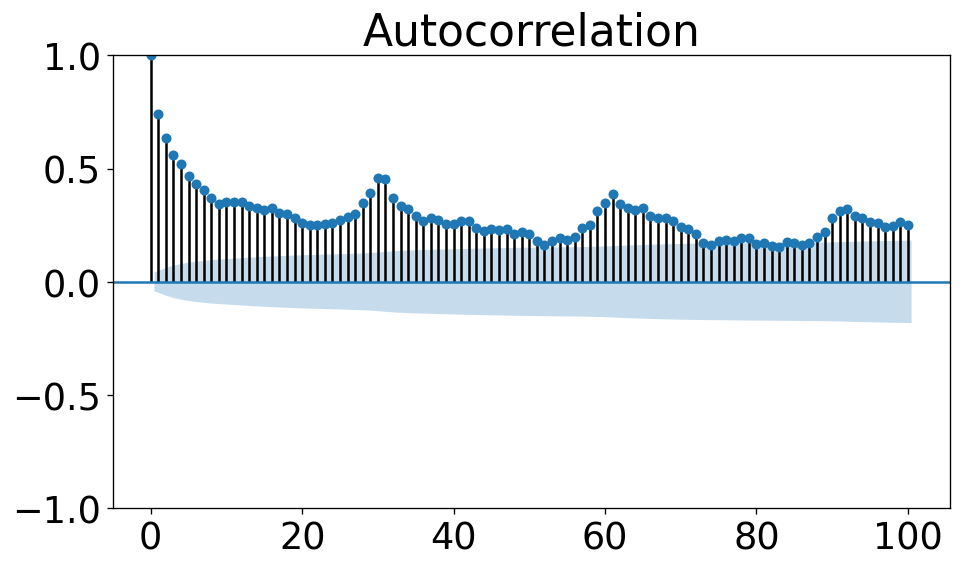

In [58]:
plot_acf(ts_diff, lags=100)

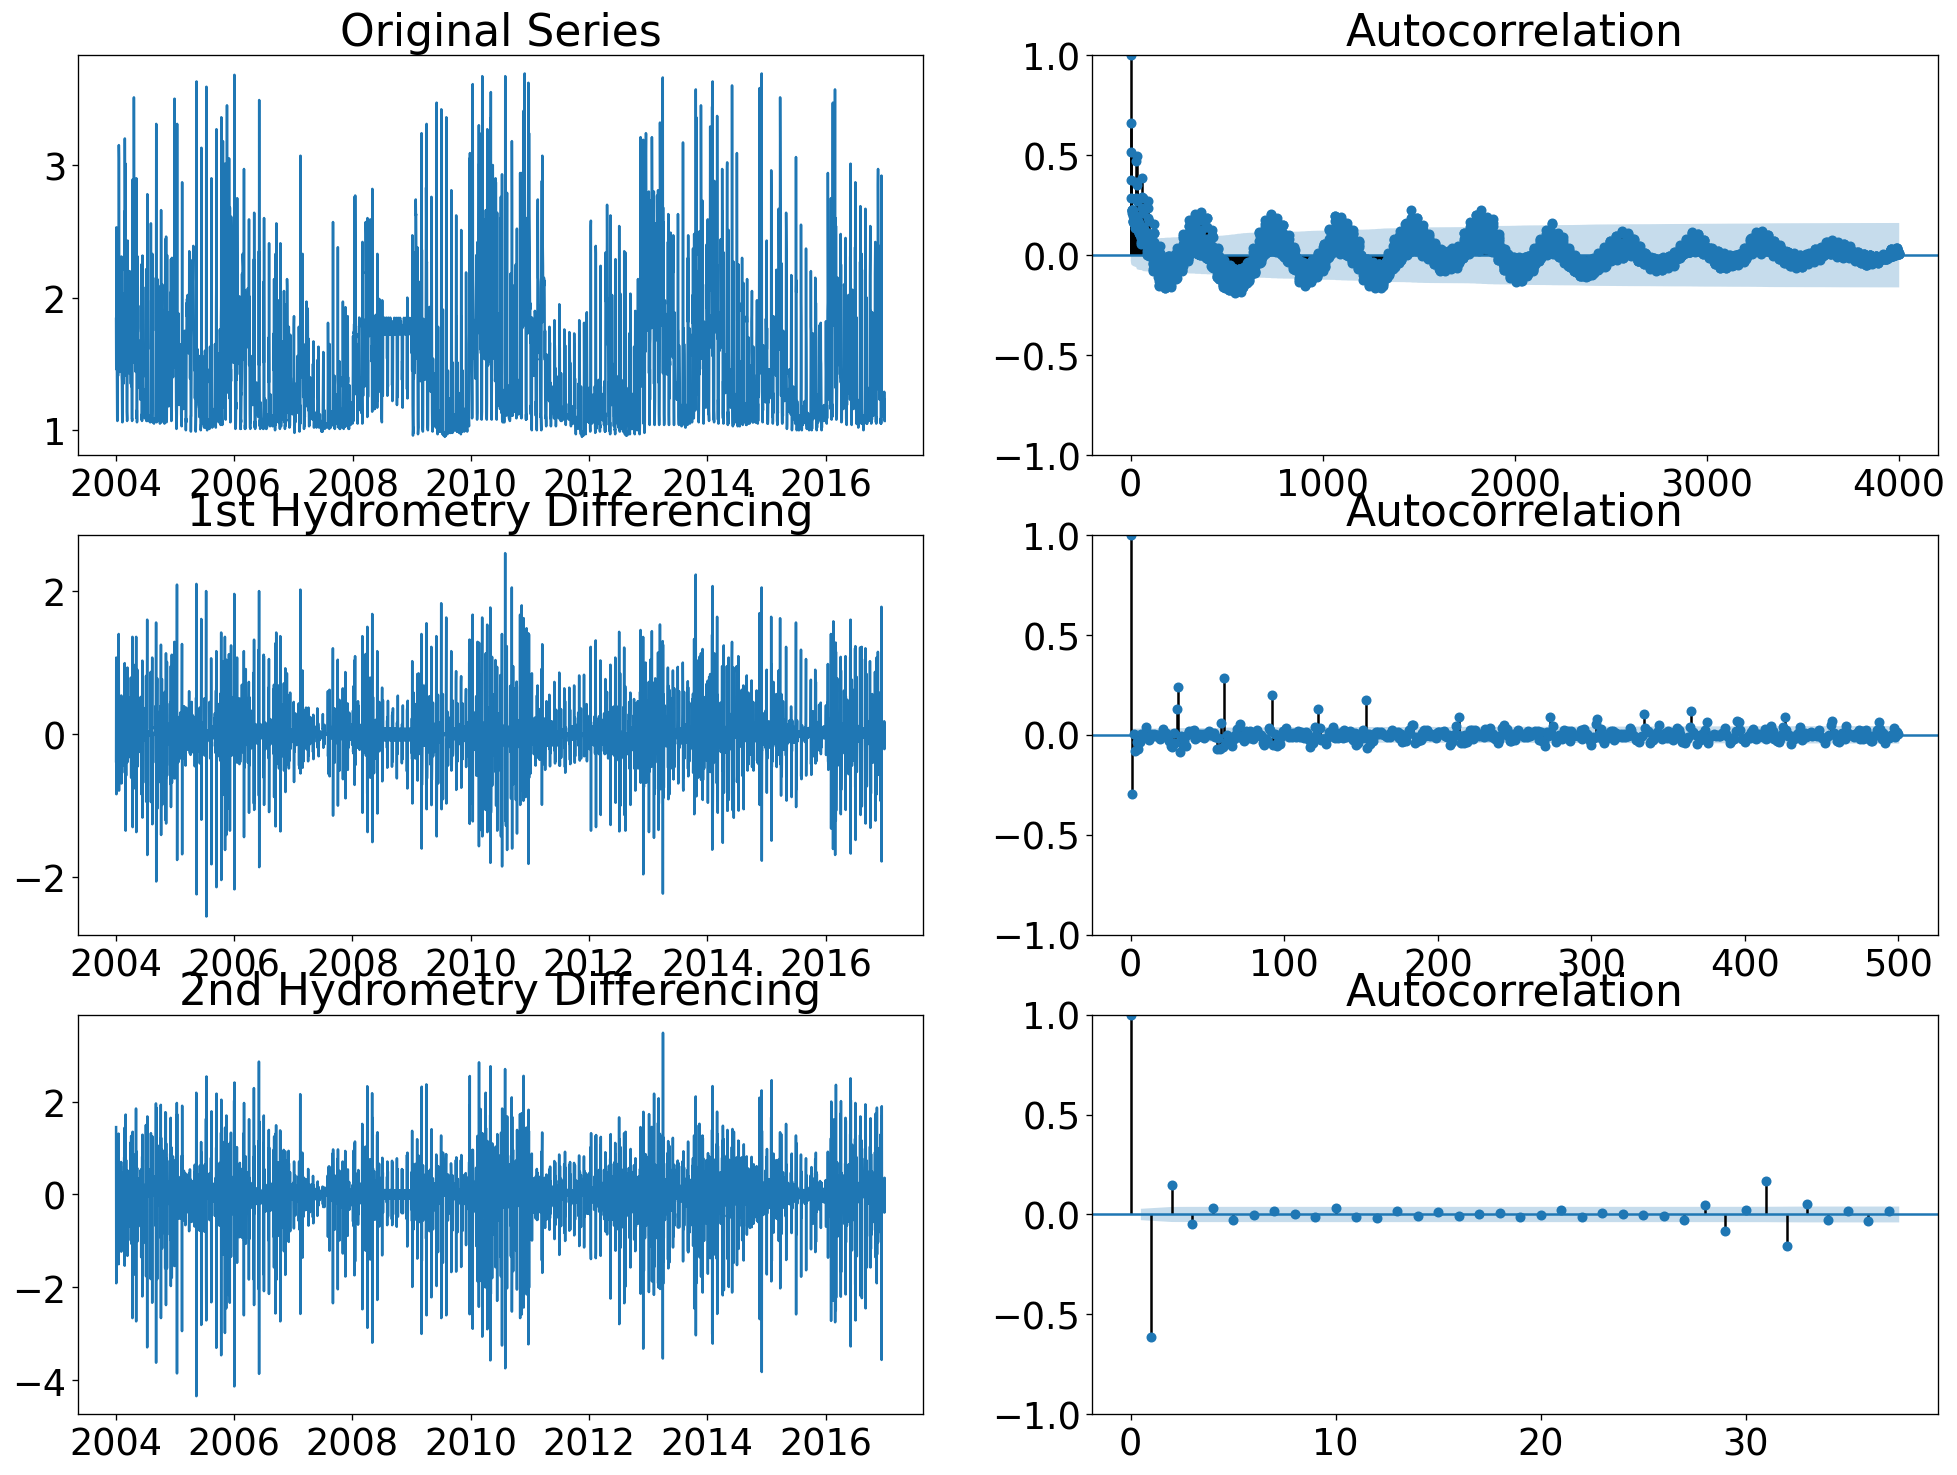

In [59]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes[0, 0].plot(ts.Hydrometry_Nave_di_Rosano); axes[0, 0].set_title('Original Series')
plot_acf(x=ts.Hydrometry_Nave_di_Rosano, ax=axes[0,1], lags=4000)

# 1st Differencing
axes[1, 0].plot(ts.Hydrometry_Nave_di_Rosano.diff()); axes[1, 0].set_title('1st Hydrometry Differencing')
plot_acf(ts.Hydrometry_Nave_di_Rosano.diff().dropna(), ax=axes[1,1], lags=500)

#2nd Differencing
axes[2, 0].plot(ts.Hydrometry_Nave_di_Rosano.diff().diff()); axes[2, 0].set_title('2nd Hydrometry Differencing')
plot_acf(ts.Hydrometry_Nave_di_Rosano.diff().diff().dropna(), ax=axes[2,1])

plt.show()

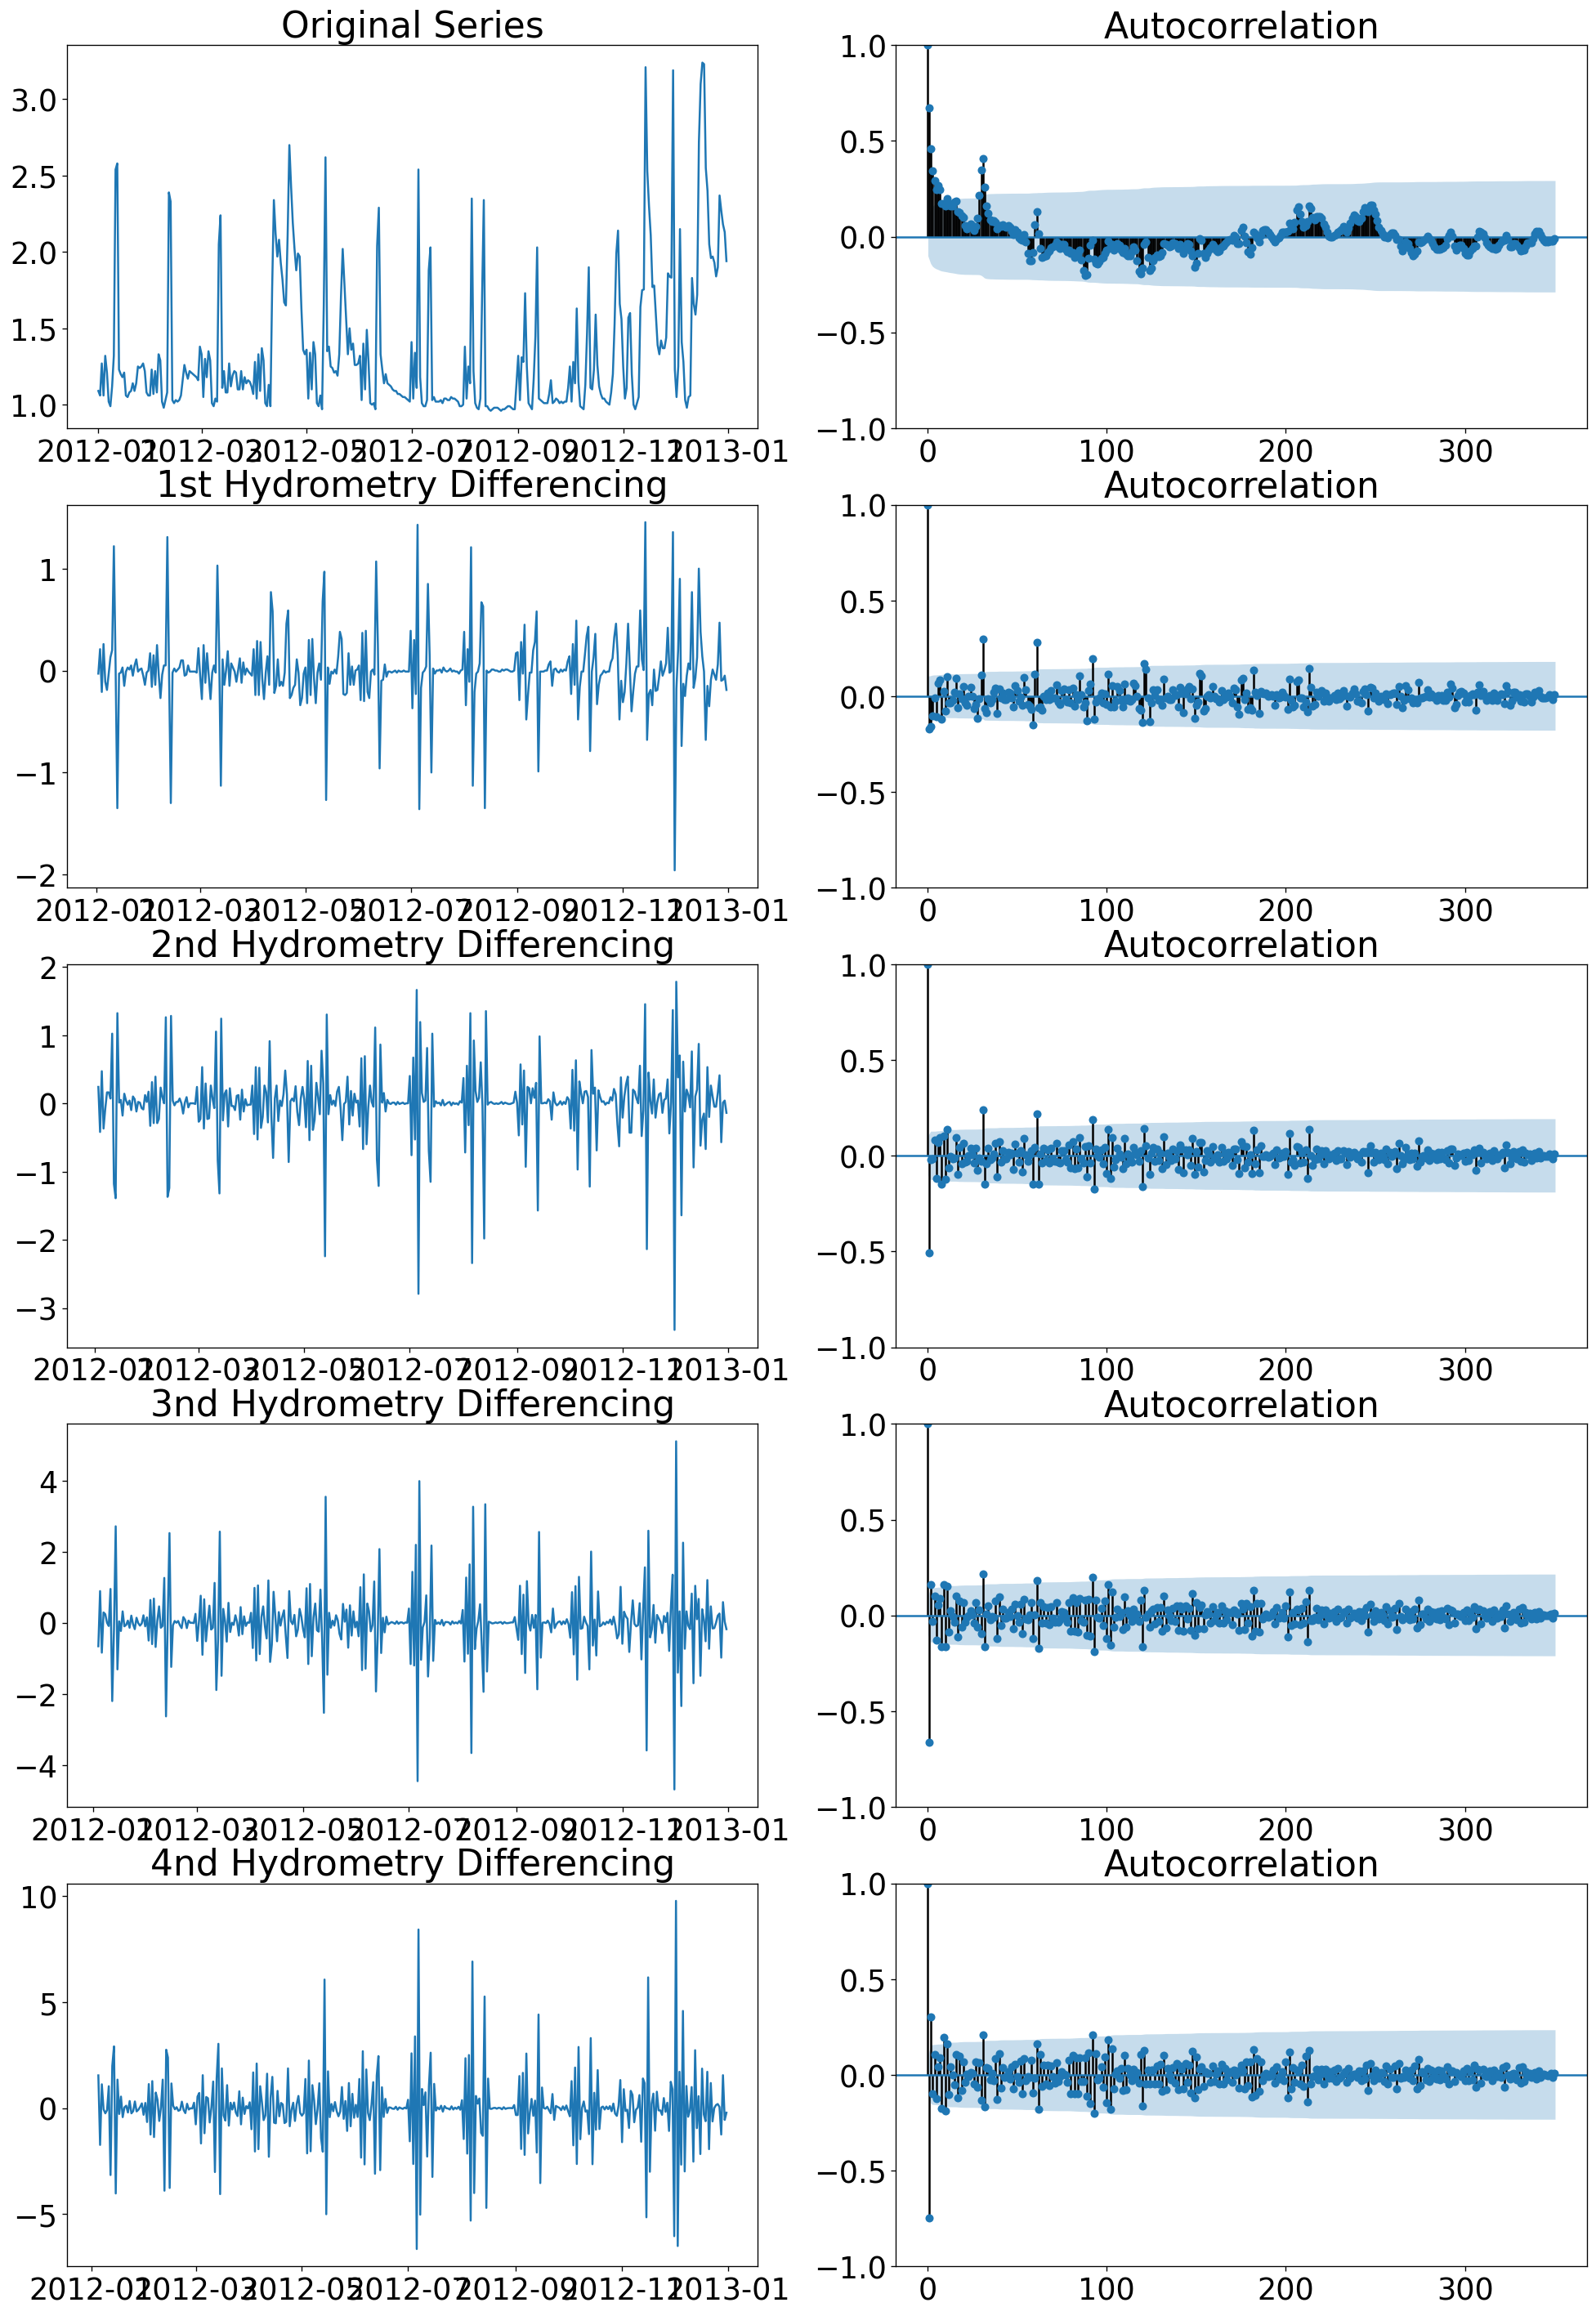

In [60]:
ts_2012 = ts['Hydrometry_Nave_di_Rosano'].loc[ts.index.year.isin([2012])]

# Original Series
fig, axes = plt.subplots(5, 2, figsize=(20, 30))
axes[0, 0].plot(ts_2012); axes[0, 0].set_title('Original Series')
plot_acf(x=ts_2012.values, ax=axes[0,1], lags=350)

# 1st Differencing
axes[1, 0].plot(ts_2012.diff()); axes[1, 0].set_title('1st Hydrometry Differencing')
plot_acf(ts_2012.diff().dropna(), ax=axes[1,1], lags=350)

#2nd Differencing
axes[2, 0].plot(ts_2012.diff().diff()); axes[2, 0].set_title('2nd Hydrometry Differencing')
plot_acf(ts_2012.diff().diff().dropna(), ax=axes[2,1], lags=350)

#3nd Differencing
axes[3, 0].plot(ts_2012.diff().diff().diff()); axes[3, 0].set_title('3nd Hydrometry Differencing')
plot_acf(ts_2012.diff().diff().diff().dropna(), ax=axes[3,1], lags=350)

#4nd Differencing
axes[4, 0].plot(ts_2012.diff().diff().diff().diff()); axes[4, 0].set_title('4nd Hydrometry Differencing')
plot_acf(ts_2012.diff().diff().diff().diff().dropna(), ax=axes[4,1], lags=350)

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


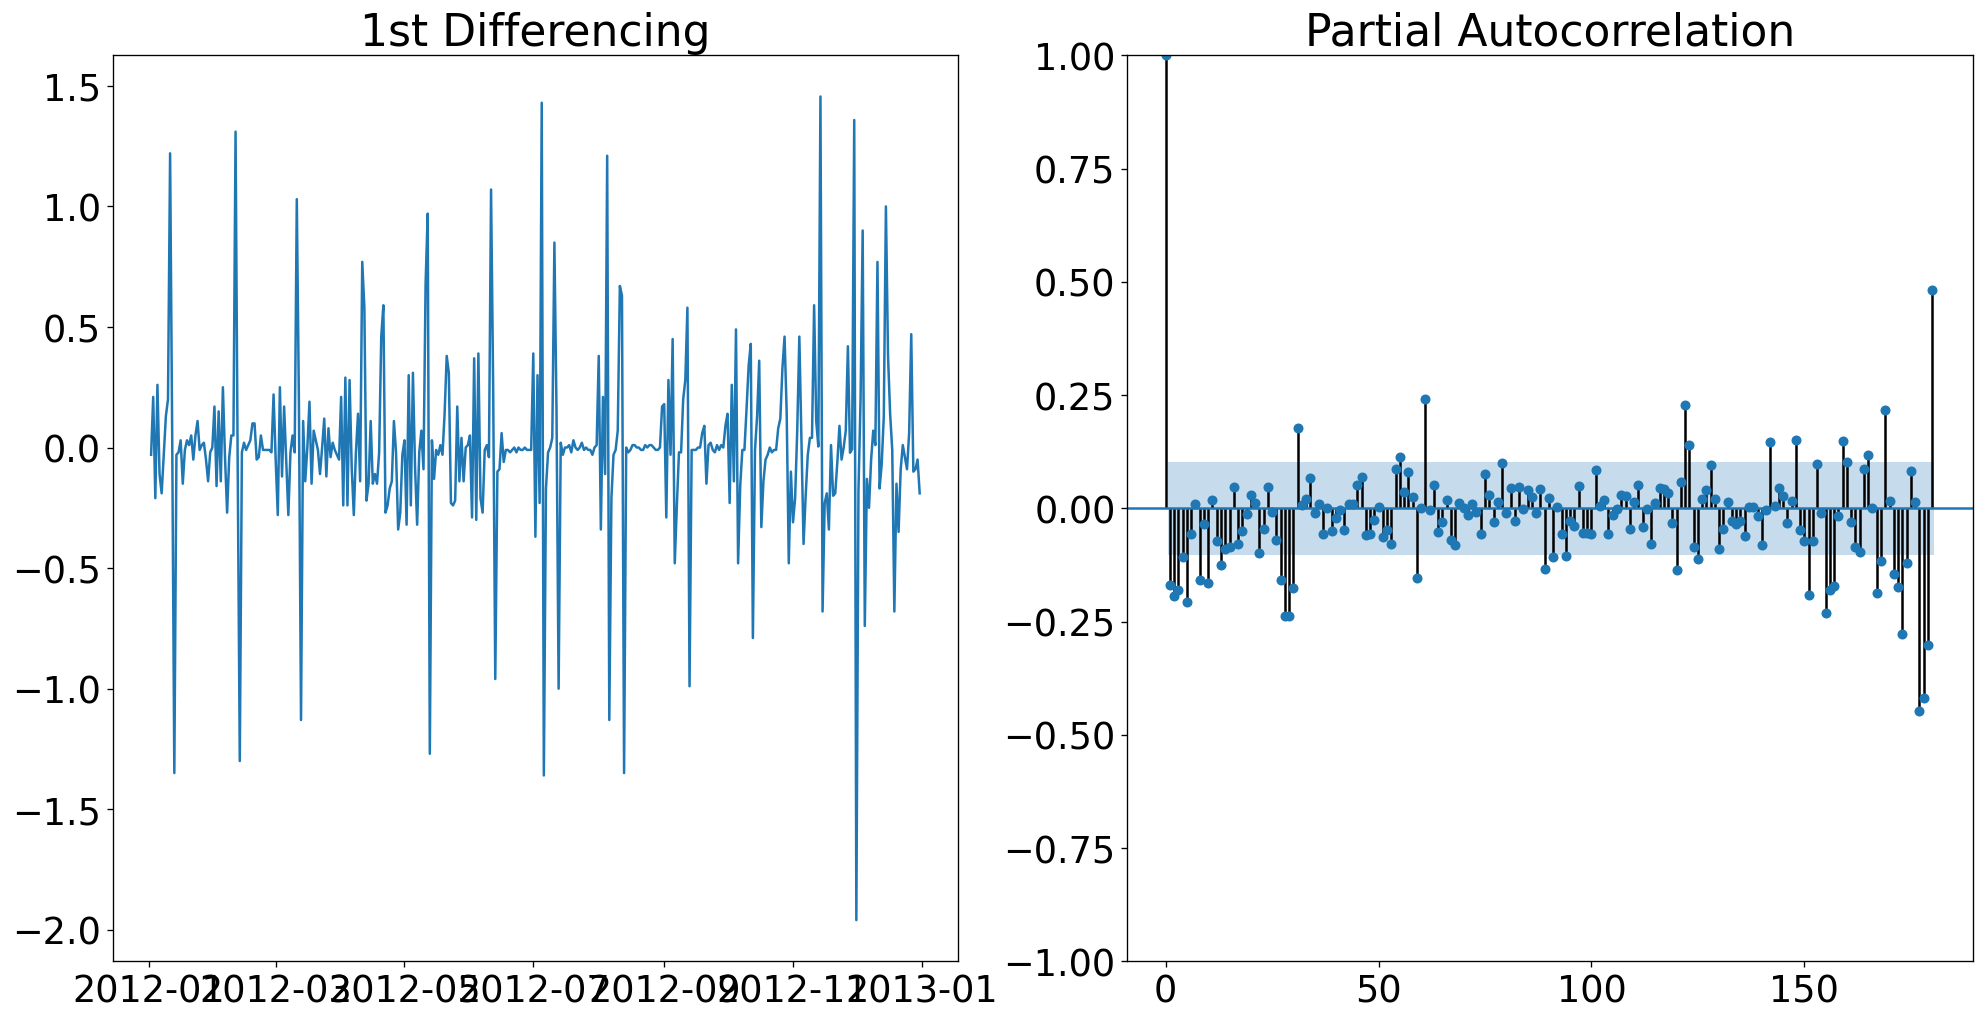

In [61]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(ts_2012.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(x=ts_2012.diff().dropna(), ax=axes[1], lags=180)


plt.show()

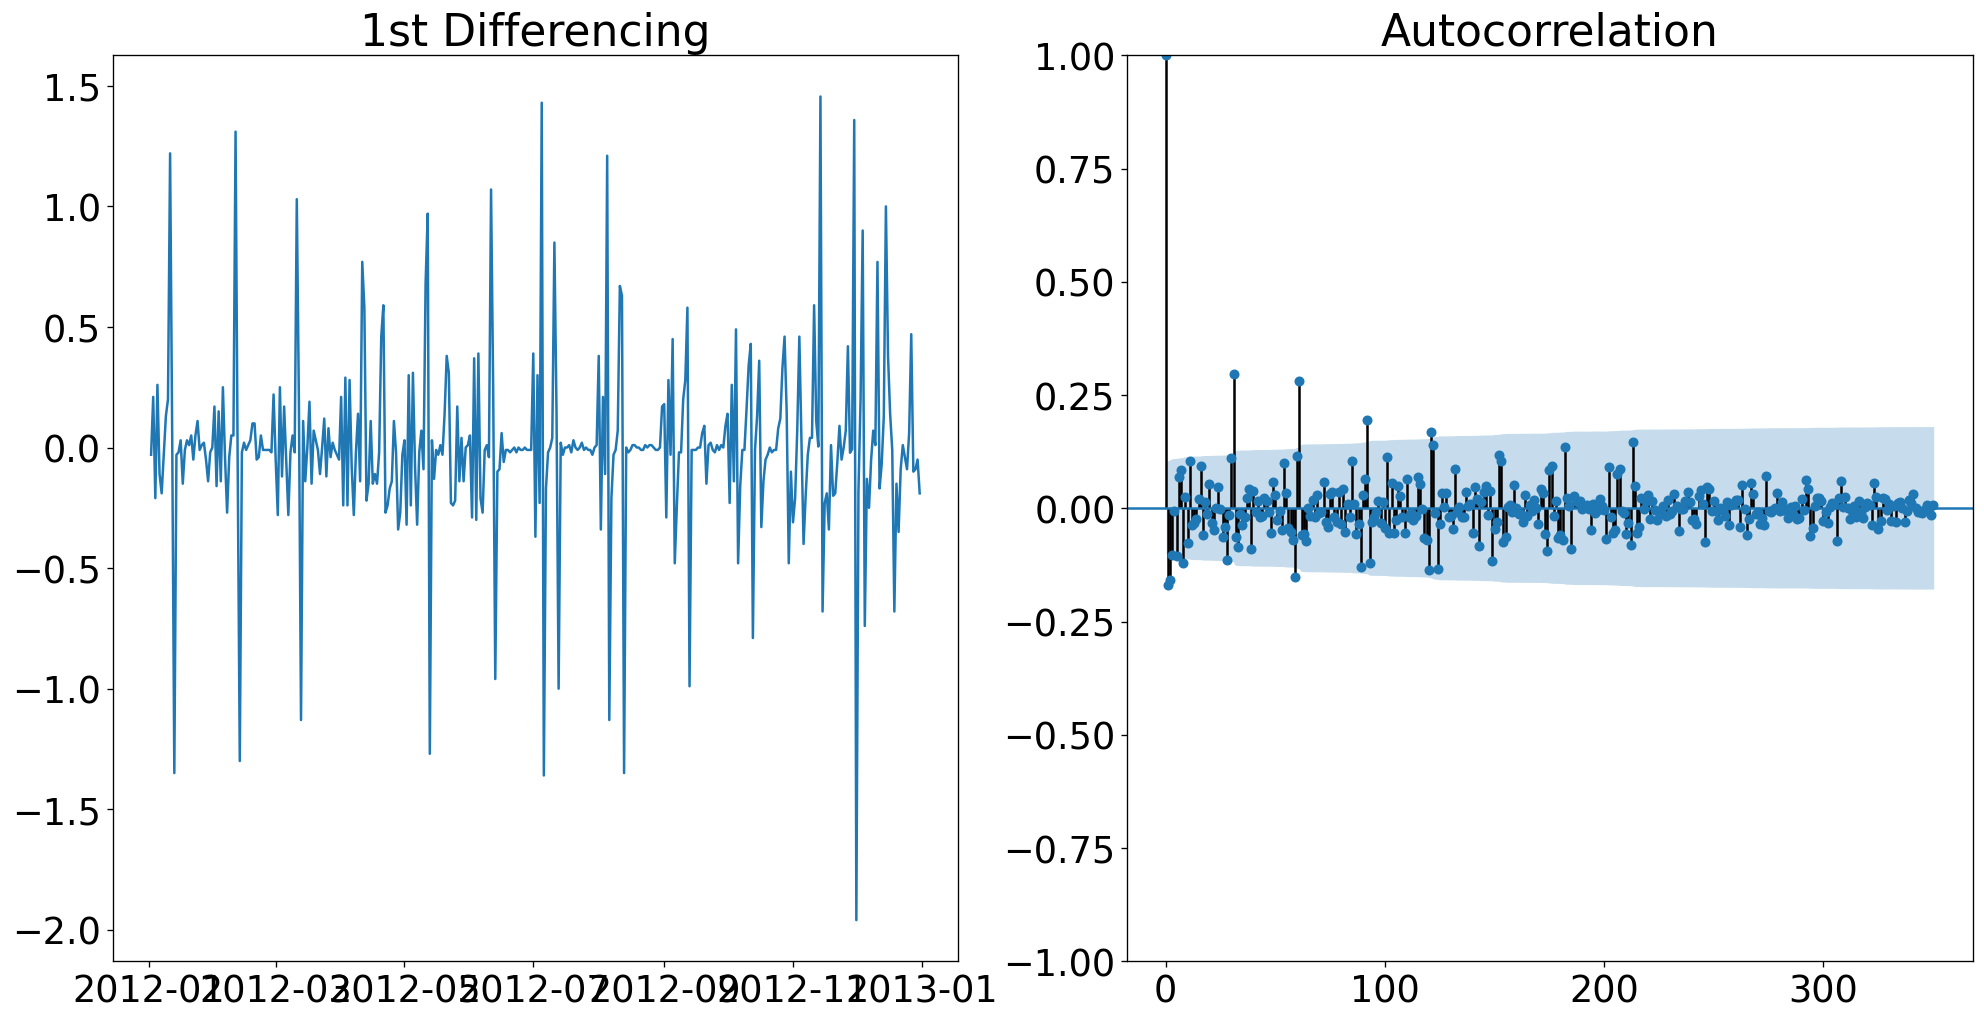

In [62]:
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2)
axes[0].plot(ts_2012.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(ts_2012.diff().dropna(), ax=axes[1], lags=350)

plt.show()

In [63]:
# 1,1,2 ARIMA Model
model = ARIMA(ts_2012, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                                   SARIMAX Results                                   
Dep. Variable:     Hydrometry_Nave_di_Rosano   No. Observations:                  366
Model:                        ARIMA(1, 1, 2)   Log Likelihood                -118.655
Date:                       Thu, 01 Sep 2022   AIC                            245.310
Time:                               11:32:35   BIC                            260.909
Sample:                           01-01-2012   HQIC                           251.509
                                - 12-31-2012                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4904      0.085      5.799      0.000       0.325       0.656
ma.L1         -0.8419      0.096     -8.755      0.000      -1.030      -0.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [64]:
# 1,1,2 ARIMA Model
order=(1,1,1)
model = ARIMA(endog=ts_2012, order=order)
res = model.fit()
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                   SARIMAX Results                                   
Dep. Variable:     Hydrometry_Nave_di_Rosano   No. Observations:                  366
Model:                        ARIMA(1, 1, 1)   Log Likelihood                -119.254
Date:                       Thu, 01 Sep 2022   AIC                            244.508
Time:                               11:32:35   BIC                            256.207
Sample:                           01-01-2012   HQIC                           249.157
                                - 12-31-2012                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5676      0.040     14.191      0.000       0.489       0.646
ma.L1         -0.9495      0.024    -39.355      0.000      -0.997      -0.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [65]:
ts_test = df_with_missing[(df_with_missing.index < "2013-05-15") & (df_with_missing.index > "2012-12-31")]
ts_test = ts_test['Hydrometry_Nave_di_Rosano'].copy()

In [66]:
predictions = pd.Series(res.forecast(len(ts_test)))
predictions = predictions.map(lambda x: x if x >= 0 else 0)
actuals = ts_test.values
print("\n MAE: \n", mean_absolute_error(predictions, actuals))


 MAE: 
 0.5864079394489227


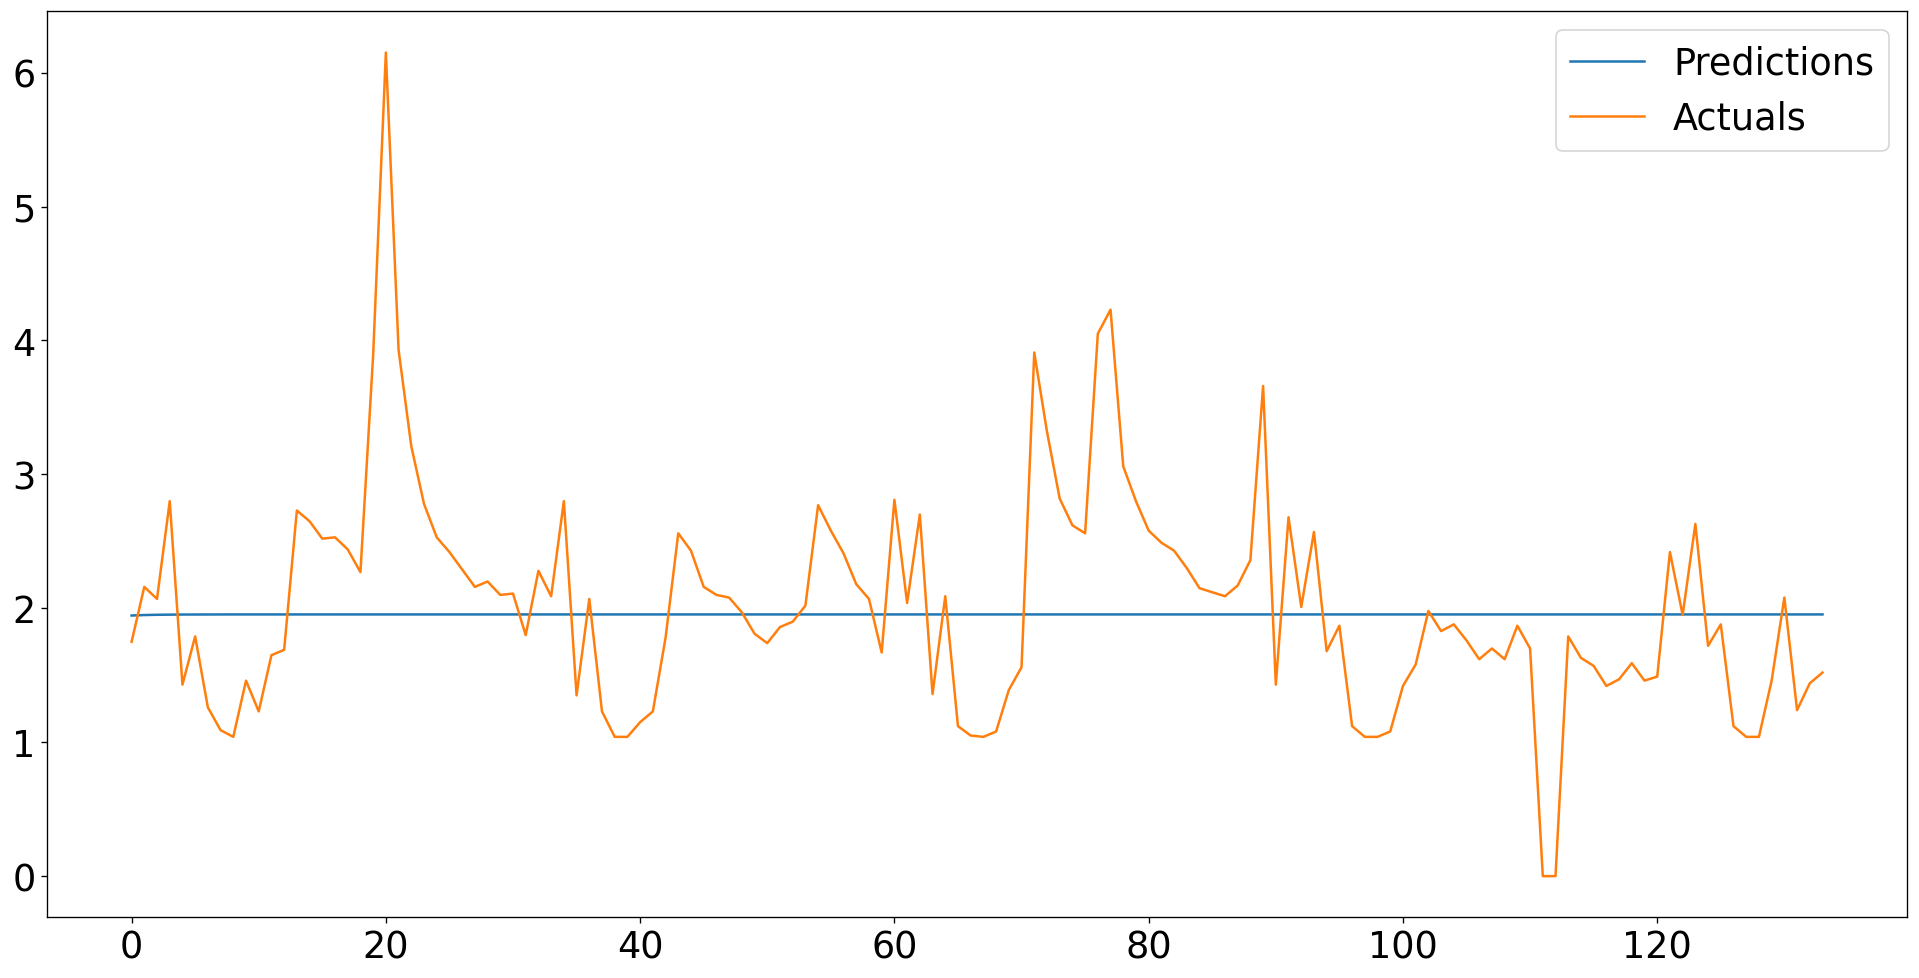

In [67]:
plt.figure(figsize=(20,10))
plt.plot(predictions.values, label='Predictions')
plt.plot(actuals, label='Actuals')
plt.legend(loc='best')

In [68]:
model = auto_arima(
  ts_2012,
  start_p=1,
  start_q=1,
  test='adf',
	trace=True,
	error_action="ignore",
	suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=253.835, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=473.388, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=251.865, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=321.683, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1300.260, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=253.841, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=247.970, Time=0.44 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=250.368, Time=0.57 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=250.066, Time=0.51 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=253.505, Time=0.22 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=254.466, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=257.049, Time=0.69 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=250.266, Time=0.28 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 3.330 seconds


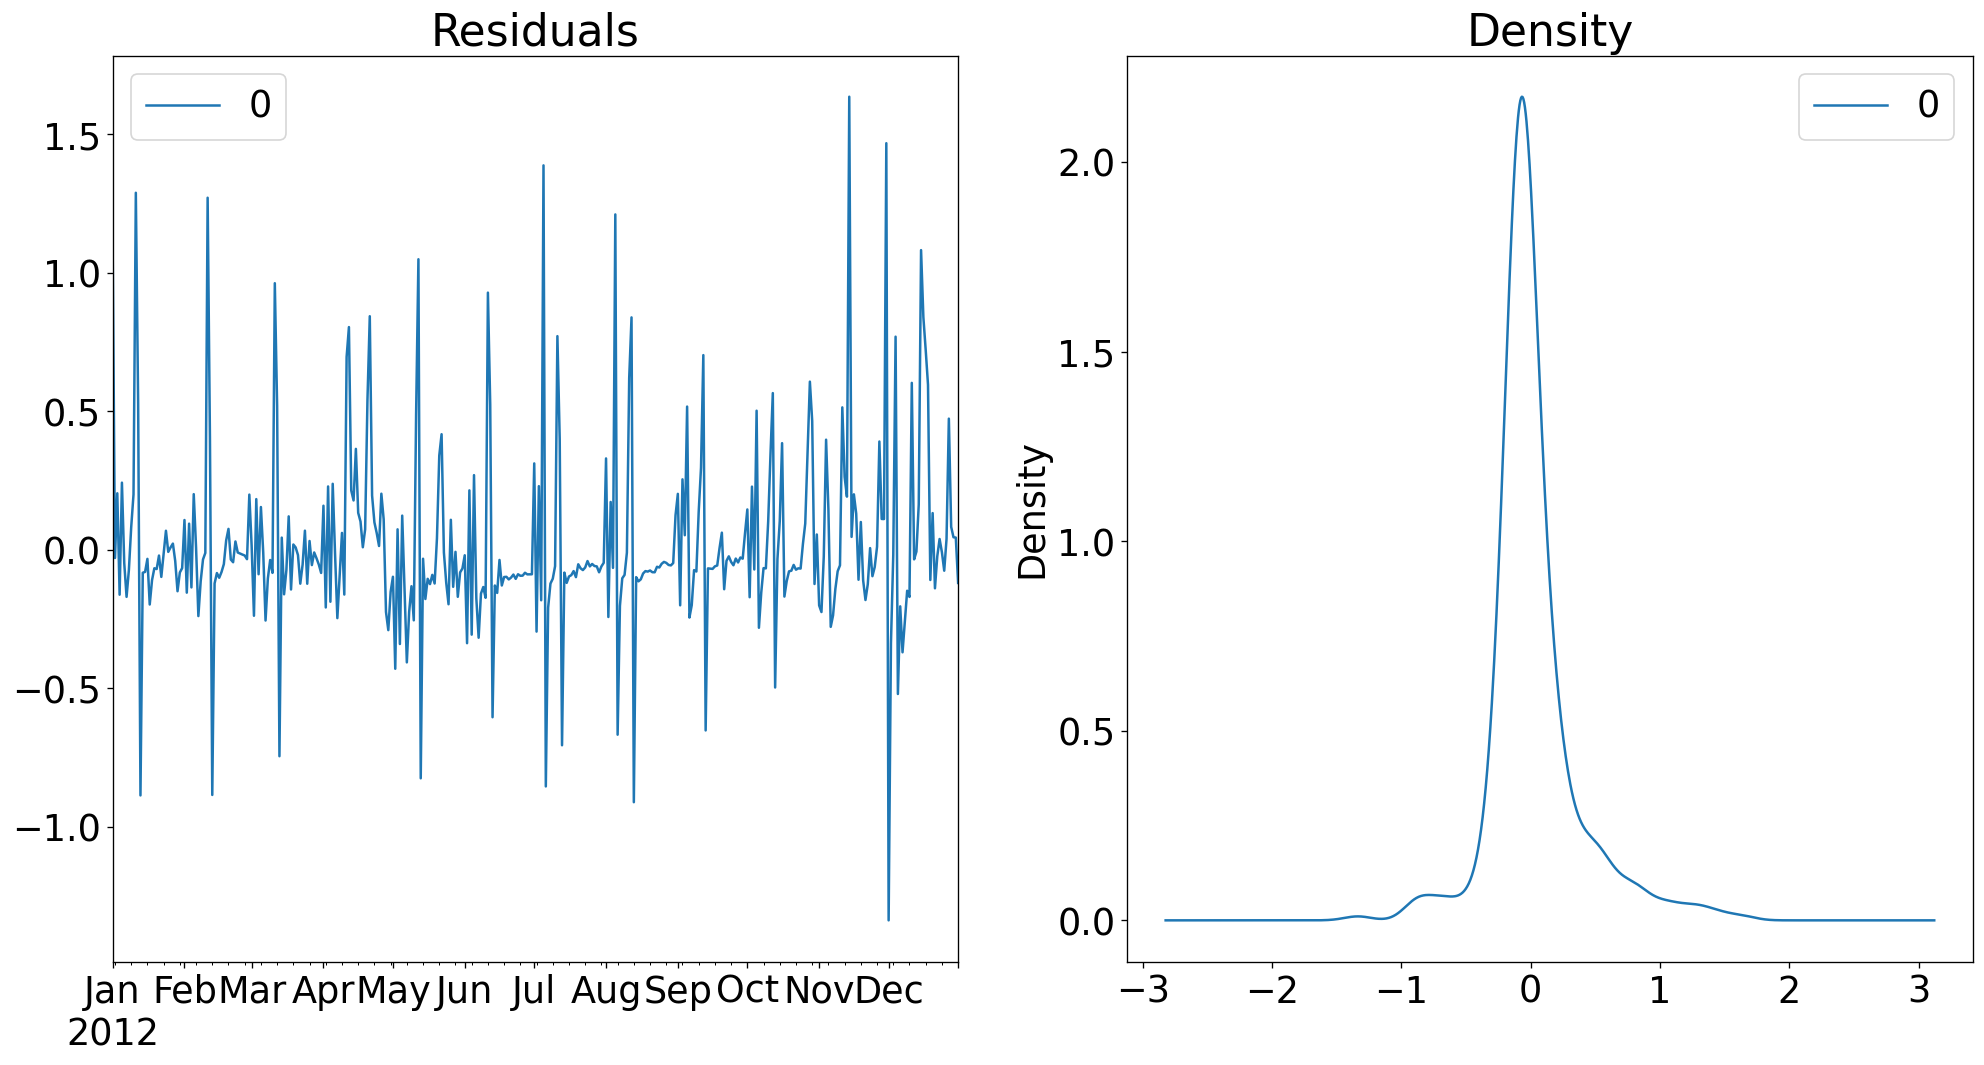

In [69]:
# Plot residual errors
residuals = pd.DataFrame(res.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [70]:
# 1,1,2 ARIMA Model
model = ARIMA(endog=ts_2012, order=(7,1,3))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zero

                                   SARIMAX Results                                   
Dep. Variable:     Hydrometry_Nave_di_Rosano   No. Observations:                  366
Model:                        ARIMA(7, 1, 3)   Log Likelihood                -110.400
Date:                       Thu, 01 Sep 2022   AIC                            242.799
Time:                               11:32:41   BIC                            285.698
Sample:                           01-01-2012   HQIC                           259.848
                                - 12-31-2012                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9752      0.069    -14.069      0.000      -1.111      -0.839
ar.L2         -0.0155      0.096     -0.161      0.872      -0.204       0.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [71]:
predictions = pd.Series(model_fit.forecast(len(ts_test)))
predictions = predictions.map(lambda x: x if x >= 0 else 0)
actuals = ts_test.values
print("\n MAE: \n", mean_absolute_error(predictions, actuals))


 MAE: 
 0.5869401101939905


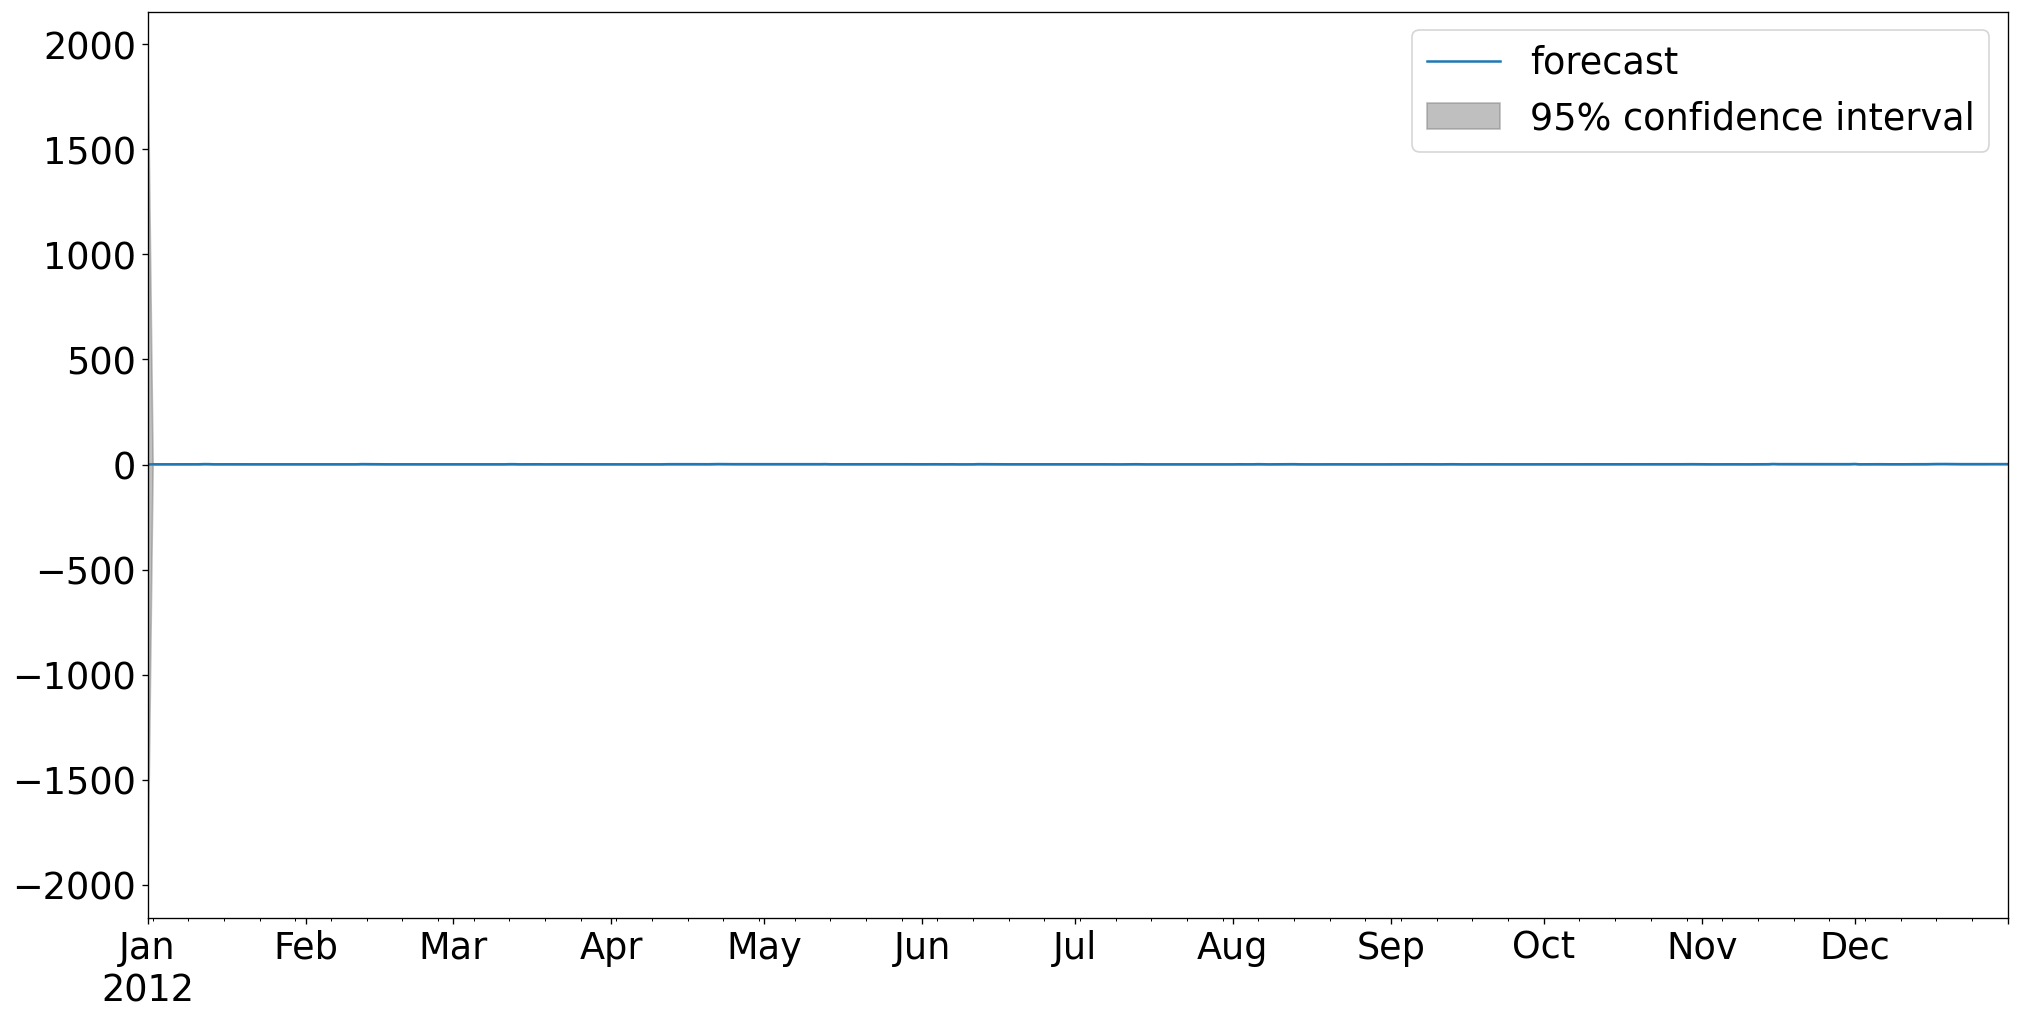

In [72]:
# Actual vs Fitted
plot_predict(model_fit, dynamic=False)
plt.show()